In [1]:
import ijson
import os
from setuptools import setup

def parse_large_json(file_path):
    # Открытие файла для потоковой обработки
    answ_list = []

    with open(file_path, 'rb') as file:
        # Потоковая обработка элементов JSON
        parser = ijson.parse(file)

        for prefix, event, value in parser:
            # тут нас интересуют элементы списков в json и событие по нахождению какого-либо ключа в этом списке
            if prefix.endswith('.item') and event == 'map_key':
                # заготовка под объект json, который будем строить
                json_object = {}
                # пока в текущем списке есть элементы, будем их анализировать

                while event == 'map_key':
                    # ijson идет итеративно по ключам и значениям
                    # поэтому сначала сохраняем уже полученный ключ,
                    # а потом запускаем следующую итерацию для получения значения
                    key = value
                    _, _, value = next(parser)
                        

                    answ_list.append(value)
                    json_object[key] = value
                    # для продолжения нашего while нам нужно снова перейти на следующий ключ списка
                    # поэтому в этой итерации мы специально сеттим event (там как раз будет map_key)
                    prefix, event, value = next(parser)

                # с построенным объектом json можем делать что угодно, тут мы сверяем его с фильтром и записываем

    return answ_list

# full_dir - полный путь до json файлов
full_dir = os.path.dirname(os.path.realpath('__file__'))

answers = parse_large_json(full_dir + '/short/answers_short.json')
questions = parse_large_json(full_dir + '/short/questions_short.json')

print('Количество вопросов: ', len(questions))
print('Количество ответов: ', len(answers))


Количество вопросов:  6
Количество ответов:  6




### Разбиение данных

In [2]:
from sklearn.model_selection import train_test_split

# Разбиение датасета на обучающий и валидационный наборы
# В этом примере `test_size=0.1` указывает, что 10% данных будут использоваться для валидации, а оставшиеся 90% — для обучения. `random_state` обеспечивает воспроизводимость разбиения
questions_train, questions_val, answers_train, answers_val = train_test_split(
    questions, answers, test_size=0.1, random_state=42
)

# Создаем список меток, 0 или 1, в зависимости от того, насколько хорошо ответ соответствует вопросу
labels_list = [1] * len(questions) # по умолчанию считаем, что все ответы соответствуют вопросу

print('Количество вопросов на обучение: ', len(questions_train))
print('Количество ответов на обучение: ', len(answers_train))

print('Количество вопросов на валидацию: ', len(questions_val))
print('Количество ответов на валидацию: ', len(answers_val))

Количество вопросов на обучение:  5
Количество ответов на обучение:  5
Количество вопросов на валидацию:  1
Количество ответов на валидацию:  1


Чтобы получить train_dataloader и val_dataloader для обучения и валидации модели BERT мы подготавливаем данные, токенизируем их и обварачиваем в DataLoader объекты из PyTorch. DataLoader позволяет итерировать по датасету с заданным размером батча.

### Подготовка и токенизация данных

Для начала токенизируем вопросы и ответы. Заготовленные данные questions_train, answers_train, questions_val, и answers_val у нас уже есть.


In [3]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_questions_answers(questions, answers, tokenizer, max_length=512):
    input_ids = []
    attention_masks = []

    for question, answer in zip(questions, answers):
        encoded_dict = tokenizer.encode_plus(
            text=question,  # Вопрос для кодирования
            text_pair=answer,  # Ответ для кодирования
            add_special_tokens=True,  # Добавление '[CLS]' и '[SEP]'
            max_length=max_length,  # Ограничение длины входных данных
            pad_to_max_length=True,  # Добавление паддинга до max_length
            return_attention_mask=True,  # Возврат маски внимания
            return_tensors='pt',  # Возврат pytorch тензоров
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Кодирование данных обучения и валидации
input_ids_train, attention_masks_train = encode_questions_answers(questions_train, answers_train, tokenizer)
input_ids_val, attention_masks_val = encode_questions_answers(questions_val, answers_val, tokenizer)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Важные моменты:

- Указываем max_length в encode_plus, соответствующую ограничениям нашей модели (например, 512 для BERT).
- Если нет меток (labels_train и labels_val), то необходимо их создать в соответствии с задачей (например, классификация или вопросно-ответная система).
- Размер батча (batch_size) можно настроить в зависимости от объема доступной памяти на устройстве. Больший размер батча ускоряет обучение, но требует больше памяти.

С этими DataLoader объектами можно выполнять обучение модели

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F


num_epochs = 10
batch_size = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class QADataset(Dataset):
    def __init__(self, questions, answers, tokenizer, labels=None, max_length=512):
        self.questions = questions
        self.answers = answers
        self.labels = labels  # Метки классов для пар вопрос-ответ
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        # Кодирование вопроса и ответа
        encoding = self.tokenizer.encode_plus(
            self.questions[idx],
            self.answers[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Для данной задачи не нужны start_positions и end_positions,
        # так как мы не пытаемся найти ответ в контексте
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        
        # Добавление метки, если она есть:
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        
        return item

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Создание Dataset
# Предположим labels уже определены
train_dataset = QADataset(questions_train, answers_train, tokenizer, labels_list)
val_dataset = QADataset(questions_val, answers_val, tokenizer, labels_list)

# Создание DataLoader'ов
train_dataloader = DataLoader(
    train_dataset,  # датасет для обучения
    batch_size=batch_size, # размер батча
    shuffle=True
    )

val_dataloader = DataLoader(
    val_dataset,  # датасет для валидации
    batch_size=batch_size,  # размер батча
    shuffle=True
)


# Инициализация модели
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
# num_labels=2 - допустим, что у нас два класса

# Оптимизатор
optimizer = AdamW(model.parameters(), lr=5e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Получение значений потерь и точности

Чтобы получить значения потерь и точности (или других метрик) на этапах обучения и валидации, нам нужно вычислить их по окончании каждой эпохи обучения.


In [5]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], [] # инициализация списков для хранения метрик


Цикл по эпохам обучения, где мы будем вычислять потери и точность на обучающем и валидационном наборах данных:


In [6]:
def flat_accuracy(preds, labels):
    pred_flat = torch.argmax(preds, dim=1).flatten()
    labels_flat = labels.flatten()
    return torch.sum(pred_flat == labels_flat).item() / len(labels_flat)


In [7]:
for epoch in range(num_epochs):
    model.train() # переключение модели в режим обучения
    total_loss, total_accuracy = 0, 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        
        loss = outputs.loss
        logits = outputs.logits
        
        total_loss += loss.item()
        
        # Вычисляем точность
        labels = batch['labels']  # предполагаем, что метки находятся в batch['labels']
        total_accuracy += flat_accuracy(logits, labels)

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = total_accuracy / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Аналогично для валидации
    model.eval()
    total_loss, total_accuracy = 0, 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            labels = batch['labels']
            total_accuracy += flat_accuracy(logits, labels)

    avg_val_loss = total_loss / len(val_dataloader)
    avg_val_accuracy = total_accuracy / len(val_dataloader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}')


Epoch 1/10, Train Loss: 0.2631, Train Accuracy: 1.0000, Validation Loss: 0.2393, Validation Accuracy: 1.0000
Epoch 2/10, Train Loss: 0.2560, Train Accuracy: 1.0000, Validation Loss: 0.2393, Validation Accuracy: 1.0000
Epoch 3/10, Train Loss: 0.2510, Train Accuracy: 1.0000, Validation Loss: 0.2393, Validation Accuracy: 1.0000
Epoch 4/10, Train Loss: 0.2434, Train Accuracy: 1.0000, Validation Loss: 0.2393, Validation Accuracy: 1.0000
Epoch 5/10, Train Loss: 0.2628, Train Accuracy: 1.0000, Validation Loss: 0.2393, Validation Accuracy: 1.0000
Epoch 6/10, Train Loss: 0.2858, Train Accuracy: 1.0000, Validation Loss: 0.2393, Validation Accuracy: 1.0000
Epoch 7/10, Train Loss: 0.2302, Train Accuracy: 1.0000, Validation Loss: 0.2393, Validation Accuracy: 1.0000
Epoch 8/10, Train Loss: 0.2292, Train Accuracy: 1.0000, Validation Loss: 0.2393, Validation Accuracy: 1.0000
Epoch 9/10, Train Loss: 0.2588, Train Accuracy: 1.0000, Validation Loss: 0.2393, Validation Accuracy: 1.0000
Epoch 10/10, Train 

In [8]:
def prepare_encodings(tokenizer, question, answer, device, max_length=512):
    # Объединяем вопрос и ответ в одну последовательность
    encoding = tokenizer.encode_plus(
        question,
        answer,
        add_special_tokens=True, # Добавляет токены [CLS] и [SEP]
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    return encoding.to(device)

1. Использование logits для оценки релевантности: для модели классификации `logits` будет содержать значения для каждого класса. Мы можем интерпретировать эти значения как меру уверенности модели в том, что пара вопрос-ответ принадлежит к определенному классу (например, классу "релевантный" и "нерелевантный").

2. Выбор класса и использование софтмакса для преобразования logits в вероятности: применение функции софтмакс к logits дает нам вероятности принадлежности к каждому классу.


In [9]:
import torch.nn.functional as F

def find_most_relevant_answer(model, tokenizer, question, answers, device):
    model.eval()
    model.to(device)
    
    max_relevance = float('-inf')
    most_relevant_answer = ""
    
    for answer in answers:
        inputs = tokenizer.encode_plus(question, answer, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits = outputs.logits
        # Применяем софтмакс для получения вероятностей
        probs = F.softmax(logits, dim=1)
        # Предполагаем, что класс 1 соответствует "релевантности"
        relevance = probs[:, 1]  # выбираем вероятность класса "релевантный"
        
        if relevance > max_relevance:
            max_relevance = relevance
            most_relevant_answer = answer
            
    return most_relevant_answer

In [10]:
# Наши записанные ответы в answers:
print("Записанные ответы:", answers)

# Наши записанные вопросы в answers:
print("Записанные вопросы:", questions)

validation_questions = ["При каких обстоятельствах возникает исключение IndexError?", 
                        "Когда возникает исключение NotImplementedError?",
                        "Как проверить, что один кортеж содержит все элементы другого кортежа?",
                        "Чувствителен ли Python к регистру?",
                        "Что такое модули Python?",
                        "Объясните, что означает «self» в Python."]


for question in validation_questions:
    most_relevant_answer = find_most_relevant_answer(model, tokenizer, question, answers, device)
    print("Задаваемый вопрос: ", question)
    print(" Ответ: ", most_relevant_answer, "\n")

Записанные ответы: ['Язык программирования считается чувствительным к регистру, если он различает такие идентификаторы, как «myname» и «Myname»', 'Модули Python — это файлы, содержащие код на Python, который представляет собой либо функциональные классы, либо переменные.', 'В Python «self» — это ключевое слово, применяемое для определения экземпляра или объекта класса. В отличие от Java, где self не является обязательным, в Python он используется как первый параметр. Self помогает отличать методы и атрибуты класса от его локальных переменных.', 'Для проверки того, содержит ли один кортеж все элементы другого кортежа в Python, можно воспользоваться встроенной функцией all(), передав ей выражение генератора списков, которое проверяет наличие каждого элемента из второго кортежа в первом кортеже: contains_all = all(elem in first_tuple for elem in second_tuple) ', 'Исключение NotImplementedError возникает, когда метод или функция должны быть реализованы в подклассе, но не были реализованы. 



### Построение графиков потерь и точности


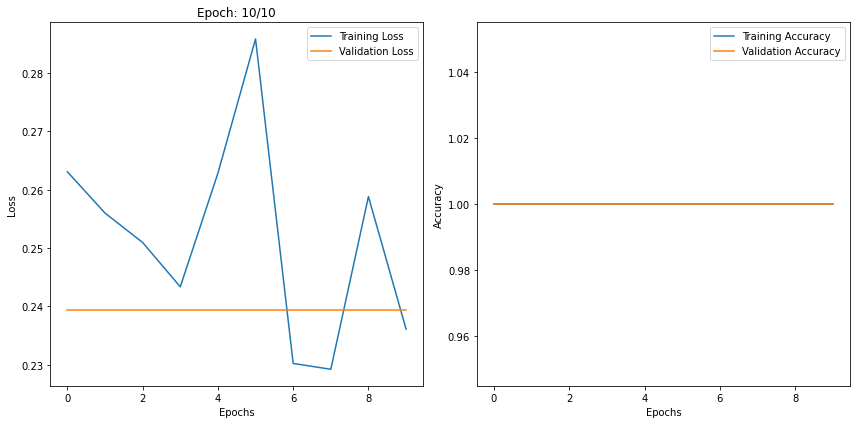

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# train_losses = []  # Список для хранения значений потерь на обучающем наборе
# val_losses = []  # Список для хранения значений потерь на валидационном наборе
# train_accuracies = []  # Список для хранения значений точности на обучающем наборе
# val_accuracies = []  # Список для хранения значений точности на валидационном наборе


for epoch in range(num_epochs):
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Epoch: {}/{}'.format(epoch + 1, num_epochs))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
